In [1]:
import random
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from PIL import Image
import os
import sys
from tqdm import tqdm
from collections import Counter, defaultdict
import csv
from pathlib import Path
from matplotlib import pyplot as plt
import json

In [2]:
# Defining project paths
project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.append(project_root) 

training_data_path = os.path.join(project_root, "PlantCLEF2025_data/images_max_side_800")
inference_data_path = os.path.join(project_root, "PlantCLEF2025_data/test_images/images")

In [ ]:
#======================================================
# Baseline 1: Apply ResNet50 multi-label classifier to 
# downscaled (224 x 224 pixels) entire quadrat images
#======================================================
'''
– Use ImageNet pretrained ResNet50, freeze most layers initially, train a multi-label head on single-plant
  images (with multi-label loss BCEWithLogits).
  
– Apply this model to downscaled quadrats (224 x 224 pixels) by running it on the entire quadrat
  image and thresholding per class.
  
– Report macro-F1 and macro-precision / macro-recall per transect. This is the “no tiling, no ViT” baseline.

'''

In [6]:
# Create inference data loader - "No Tiling" - for ResNet50
from loading import quadrat_loader

IMG_SIZE = 224 
BATCH_SIZE = 32
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader = quadrat_loader.main(inference_data_path, 
                                   tiles_per_side=1,   # no tiling for the inital Baseline 1
                                   target_size=IMG_SIZE, 
                                   batch_size=BATCH_SIZE, 
                                   num_workers=NUM_WORKERS)


Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---


In [4]:
# Check full inference data and data loader size (66 minibatches)
len(inference_data), len(inference_loader)

(2105, 66)

In [6]:
# Check the first minibatch and content dimensions (an example of batch_size=2)
# data_batch, labels_batch = next(iter(inference_loader))

# print(f"Batch data shape: {data_batch.shape}")   # (Batch_size x num_Tiles x num_Channels x Width x Height)
# print(f"Batch label - path for quadrat image: {labels_batch}")   # (batch size = number of images in the batch)

Batch data shape: torch.Size([2, 1, 3, 224, 224])
Batch label - path for quadrat image: ('/sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images/2024-CEV3-20240602.jpg', '/sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images/CBN-PdlC-A1-20130807.jpg')


In [5]:
# Get the trained ResNet50 multi-label classifier and initialize configuration
from resnet50 import resnet50_multilabel   # get pretrained ResNet50 and helper functions

NUM_CLASS = 7806

resnet50_multilabel_model = resnet50_multilabel.get_resnet50_pretrained(num_classes=NUM_CLASS, fine_tune=False)
state_dict = torch.load('resnet50_multilabel_finetune_plantCLEF.pth', map_location=torch.device('cpu'), weights_only=True)  # weights_only=True is recommended for security
resnet50_multilabel_model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
# Load the saved (idx-cls, cls-idx) mapping dictionaries back:
with open('cls_to_idx_mapdict.json', 'r') as f:
    cls_to_idx_mapdict = json.load(f)

with open('idx_to_cls_mapdict.json', 'r') as g:
    idx_to_cls_mapdict = json.load(g)
    
print(f"Mapping dictionaries loaded!\n")

Mapping dictionaries loaded!



In [5]:
# Inference / Prediction function

def multi_label_prediction(model, dataloader, device, threshold=0.5):
    model.eval().to(device)
    all_preds_idx = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc='Predicting'):   # only move imgs to GPU for inference
            imgs = imgs.squeeze().to(device)   # getting rid of the 2nd dim (num_Tiles) since no tiling performed
                                               # for multiple tiles, this is to get rid of the 1st dim since batch_size=1
            logits = model(imgs)
            preds_prob = torch.sigmoid(logits)    # convert to probabilities
            preds_multihot = (preds_prob > threshold).float()  # threshold

            # process results for each batch
            logits = logits.cpu()   # move back to memory
            preds_multihot = preds_multihot.cpu()   # move predictions back to memory
            preds_idx = [np.where(row == 1)[0] for row in preds_multihot]   # get the indices based on multihot
           
            if len(labels) == 1:   # for multiple tiling cases
                quadrat_preds = {}
                quadrat_id = Path(labels[0]).stem
                quadrat_preds[quadrat_id] = preds_idx
                all_preds_idx.append(quadrat_preds)
                
            else:    # for non-tiling
                quadrat_ids = [Path(path).stem for path in labels]   # extract quadrat_id, already in memory   
                batch_preds = dict(zip(quadrat_ids,preds_idx))                           
                all_preds_idx.append(batch_preds)
                
    return all_preds_idx   # return multi-label indices for each image as {quadrat_id: [pred_idx]}
                           # results will be a list of dictionaries (each dict represents a minibatch), with
                           # each dictionary containing the quadrat IDs and their predicted indices (idx) of a minibatch 

In [50]:
# Inference / Prediction with the default threshold of 0.5

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

all_preds_multihot = multi_label_prediction(resnet50_multilabel_model, inference_loader, DEVICE)

Using device: cuda


Predicting: 100%|██████████| 66/66 [01:46<00:00,  1.61s/it]


In [51]:
# Results will be a list of 66 dictionaries
# with each dictionary containing the quadrat IDs and their predicted indices (idx) of a minibatch (size 32) 

len(all_preds_multihot), len(all_preds_multihot[0])

(66, 32)

In [82]:
# Quickly check the minibatch result dictionary
for i, (k,v) in enumerate(all_preds_multihot[0].items()):
    print(k,v)
    if i>=5:
        break

2024-CEV3-20240602 []
CBN-PdlC-A1-20130807 []
CBN-PdlC-A1-20130903 []
CBN-PdlC-A1-20140721 [5373]
CBN-PdlC-A1-20140811 []
CBN-PdlC-A1-20140901 []


In [83]:
# Concat all predictions in to one dataframe
result_df = pd.DataFrame(columns=["quadrat_id", "species_idx"])
for dict in all_preds_multihot:
    df_i = pd.DataFrame([[k,v.tolist()] for k, v in dict.items()], columns=["quadrat_id", "species_idx"])
    result_df = pd.concat([result_df, df_i],ignore_index=True)

result_df

,quadrat_id,species_idx
0,2024-CEV3-20240602,[]
1,CBN-PdlC-A1-20130807,[]
2,CBN-PdlC-A1-20130903,[]
3,CBN-PdlC-A1-20140721,[5373]
4,CBN-PdlC-A1-20140811,[]
...,...,...
2100,RNNB-8-5-20240118,[]
2101,RNNB-8-6-20240118,[]
2102,RNNB-8-7-20240118,[]
2103,RNNB-8-8-20240118,[]


In [78]:
idx_to_cls_mapdict['5373']

'1398824'

In [84]:
# Adding the "species_ids" column to the dataframe

ids_col = []

for quadrat in result_df['species_idx']:
    quadrat_preds = []
    for idx in quadrat:
        cls = idx_to_cls_mapdict[str(idx)]
        quadrat_preds.append(cls)
    ids_col.append(quadrat_preds)

result_df['species_ids'] = ids_col
result_df

,quadrat_id,species_idx,species_ids
0,2024-CEV3-20240602,[],[]
1,CBN-PdlC-A1-20130807,[],[]
2,CBN-PdlC-A1-20130903,[],[]
3,CBN-PdlC-A1-20140721,[5373],[1398824]
4,CBN-PdlC-A1-20140811,[],[]
...,...,...,...
2100,RNNB-8-5-20240118,[],[]
2101,RNNB-8-6-20240118,[],[]
2102,RNNB-8-7-20240118,[],[]
2103,RNNB-8-8-20240118,[],[]


In [86]:
# Save dataframe for submission
submit_df = result_df[["quadrat_id", "species_ids"]]
submit_df.to_csv("hl9h_baseline_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

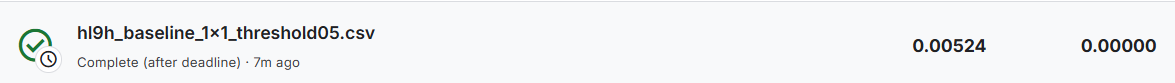
##### I can see that with a threshold of 0.5, the model predicted just a few pecices, leaving most of the quadrats without any prediction. Not suprisingly, the F1-score I got from Kaggle were 0.005 for private board and 0.0 for public board . This indicates that the big difference in the test data and the large image downscaling/compression (224x224) greatly affected the model prediction confidence. 

In [6]:
# Create a function to process model prediction/inference results into a dataframe
def pred_idx_to_df(all_preds_idx: list) -> pd.DataFrame:
    result_df = pd.DataFrame(columns=["quadrat_id", "species_idx"])
    ids_col = []
    
    for dict in all_preds_idx:
        if len(dict) == 1:   # for multiple tiling cases
            k, v = next(iter(dict.items()))
            idx_lst = []
            for i in v:   # v is a nested list of list of indices
                if len(i) != 0:
                    for sub_i in i:
                        idx_lst.append(int(sub_i))
            
            df_i = pd.DataFrame({"quadrat_id":k, "species_idx":[idx_lst]})
            result_df = pd.concat([result_df, df_i],ignore_index=True)

        else:   # for non-tiling case
            df_i = pd.DataFrame([[k,v.tolist()] for k, v in dict.items()], columns=["quadrat_id", "species_idx"])
            result_df = pd.concat([result_df, df_i],ignore_index=True)
     
    for quadrat in result_df['species_idx']:
        quadrat_preds = []
        for idx in quadrat:
            cls = idx_to_cls_mapdict[str(idx)]
            quadrat_preds.append(cls)
        ids_col.append(quadrat_preds)
    
    result_df['species_ids'] = ids_col
    return result_df


In [14]:
# Stepwise threshold scanning - from 0.5 to 0.1

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.4, 0.3, 0.2, 0.1]
result_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = multi_label_prediction(resnet50_multilabel_model, inference_loader, DEVICE, threshold=thd)    
    result_df = pred_idx_to_df(idx_list)
    result_df_list.append(result_df)
# This returns a list of 4 dataframes - each dataframe is the inference result of the whole test data with
# a different threshold (from 0.4 to 0.1).

Using device: cpu
Scanning thresholds ... 



Predicting: 100%|██████████| 66/66 [04:12<00:00,  3.82s/it]


In [16]:
# Quickly check the result list and its containing dataframes
len(result_df_list), result_df_list[0].shape

(4, (2105, 3))

In [17]:
# Save dataframes for submission
submit_df_thd04 = result_df_list[0][["quadrat_id", "species_ids"]]
submit_df_thd03 = result_df_list[1][["quadrat_id", "species_ids"]]
submit_df_thd02 = result_df_list[2][["quadrat_id", "species_ids"]]
submit_df_thd01 = result_df_list[3][["quadrat_id", "species_ids"]]

submit_df_thd04.to_csv("hl9h_baseline_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd03.to_csv("hl9h_baseline_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd02.to_csv("hl9h_baseline_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd01.to_csv("hl9h_baseline_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

In [18]:
result_df_list[3]

,quadrat_id,species_idx,species_ids
0,2024-CEV3-20240602,[],[]
1,CBN-PdlC-A1-20130807,[],[]
2,CBN-PdlC-A1-20130903,[],[]
3,CBN-PdlC-A1-20140721,"[2432, 5373]","[1363426, 1398824]"
4,CBN-PdlC-A1-20140811,[],[]
...,...,...,...
2100,RNNB-8-5-20240118,[],[]
2101,RNNB-8-6-20240118,[],[]
2102,RNNB-8-7-20240118,[3378],[1391750]
2103,RNNB-8-8-20240118,[3501],[1392164]


In [221]:
# Reformating the submission data frames
from ast import literal_eval
submit_df_thd01 = pd.read_csv("hl9h_baseline_threshold01.csv")
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(literal_eval)   # remove quotes ""
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd01.to_csv("hl9h_baseline_1x1_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

submit_df_thd02 = pd.read_csv("hl9h_baseline_threshold02.csv")
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(literal_eval)   # remove quotes ""
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd02.to_csv("hl9h_baseline_1x1_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

submit_df_thd03 = pd.read_csv("hl9h_baseline_threshold03.csv")
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(literal_eval)   # remove quotes ""
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd03.to_csv("hl9h_baseline_1x1_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

submit_df_thd04 = pd.read_csv("hl9h_baseline_threshold04.csv")
submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(literal_eval)   # remove quotes ""
submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd04.to_csv("hl9h_baseline_1x1_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

submit_df_thd05 = pd.read_csv("hl9h_baseline_threshold05.csv")
submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(literal_eval)   # remove quotes ""
submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd05.to_csv("hl9h_baseline_1x1_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)


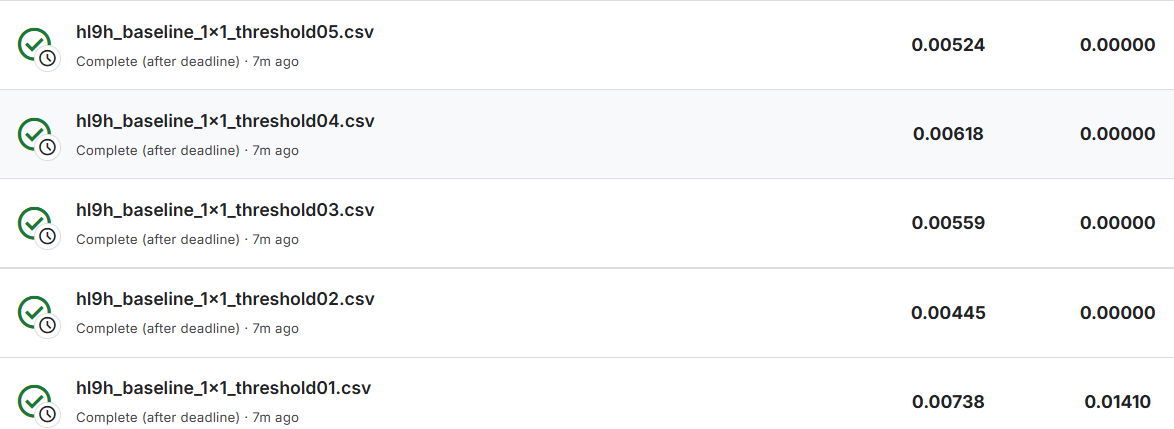
##### I can see that lowering the threshold did make the model predicted many more species per quadrat, there are still a large number of quadrats left unclassified and the F1-scores are still not promising. A threshold of 0.1 led to the most number of multi-labels predicted, which gave the highest F1-scores within the group (no-tiling + threshold scanning).

In [7]:
# Keep scanning threshold from 0.6 to 0.7 

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.7, 0.6]
result_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result_df_list.append(result_df)


Using device: cuda
Scanning thresholds ... 



Predicting:   0%|          | 0/66 [00:00<?, ?it/s]


IsADirectoryError: Caught IsADirectoryError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/hl9h/.local/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/hl9h/.local/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/sfs/weka/scratch/hl9h/loading/quadrat_loader.py", line 43, in __getitem__
    img = Image.open(path).convert("RGB")
          ^^^^^^^^^^^^^^^^
  File "/apps/software/standard/core/jupyterlab/4.4.6-py3.12/lib/python3.12/site-packages/PIL/Image.py", line 3513, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
IsADirectoryError: [Errno 21] Is a directory: '/sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images/.ipynb_checkpoints'


In [10]:
# Save dataframes for submission
submit_df_thd07 = result_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd06 = result_df_list[1][["quadrat_id", "species_ids"]].copy()

submit_df_thd07['species_ids'] = submit_df_thd07['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd06['species_ids'] = submit_df_thd06['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd07.to_csv("hl9h_baseline_1x1_threshold07.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd06.to_csv("hl9h_baseline_1x1_threshold06.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)


In [ ]:
#======================================================
# Baseline 2: ResNet50 multi-label classifier + Tiling
#======================================================
'''
– Implement an end-to-end script that (1) tiles quadrats into an NxN grid, (2) runs the ResNet50 classifier
  on each tile, (3) aggregates per-species scores across tiles.
  
– Start with two discrete settings, for example:  N in {3, 5}, overlap in {0%, 25%}.

– Compare macro-F1 of these tiled variants against the non-tiled baseline.

'''

In [11]:
# Create inference data loader - "Different Tiling Strategies" - for ResNet50
# Due to the high resolution of the quadrat images (e.g., 3240 x 2764) and the 
# relatively small input size for ResNet50 (i.e., 224 x 224), I speculate that 
# a relatively large number of tiles (e.g., 10 x 10) may help capture details in a quadrat.

from loading import quadrat_loader

TILES_PER_SIDE = 3   # starting from 3x3 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader_t3 = quadrat_loader.main(     # t3: tiling of 3x3
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)


Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---


In [12]:
# Check full inference data and data loader size 
len(inference_data), len(inference_loader_t3)   # 2105 minibatches - handle quadrats individually

(2105, 2105)

In [13]:
# A quick check on each minibatch structure
data_batch, labels_batch = next(iter(inference_loader_t3))

print(f"Batch data shape: {data_batch.shape}")   # (Batch_size x num_Tiles x num_Channels x Width x Height)
print(f"Batch label - path for quadrat image: {labels_batch}")   # during prediction bactch size is implicitly num_Tiles,
                                                                 # since the 1st dim will be squeezed,
                                                                 # each batch = one quadrat (of num_Tiles tiles)

Batch data shape: torch.Size([1, 9, 3, 224, 224])
Batch label - path for quadrat image: ('/sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images/2024-CEV3-20240602.jpg',)


In [177]:
# Inference / Prediction at 3x3 tiling with default threshold of 0.5

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

# The resulting 'idx_pred_results' will be a list of 2105 dictionaries (each dict represents one quadrat)
idx_pred_results = multi_label_prediction(resnet50_multilabel_model, inference_loader_t3, DEVICE)    


Using device: cpu


Predicting: 100%|██████████| 2105/2105 [16:19<00:00,  2.15it/s]


In [181]:
# Confirm the shape of output
len(idx_pred_results), len(idx_pred_results[0])

(2105, 1)

In [182]:
result_df = pred_idx_to_df(idx_pred_results)
result_df

,quadrat_id,species_idx,species_ids
0,2024-CEV3-20240602,[],[]
1,CBN-PdlC-A1-20130807,"[5120, 7062]","[1397439, 1738641]"
2,CBN-PdlC-A1-20130903,[4103],[1393939]
3,CBN-PdlC-A1-20140721,"[2554, 6845]","[1363741, 1722444]"
4,CBN-PdlC-A1-20140811,[4059],[1393824]
...,...,...,...
2100,RNNB-8-5-20240118,[],[]
2101,RNNB-8-6-20240118,[],[]
2102,RNNB-8-7-20240118,[],[]
2103,RNNB-8-8-20240118,[1102],[1359344]


In [190]:
# Save the dataframe for submission
submit_df = result_df[["quadrat_id", "species_ids"]].copy()
submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df.to_csv("hl9h_baseline_3x3_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

In [10]:
# Inference / Prediction at 3x3 tiling with stepwise threshold scanning - 0.4 to 0.1

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.4, 0.3, 0.2, 0.1]
result3x3_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = multi_label_prediction(resnet50_multilabel_model, inference_loader_t3, DEVICE, threshold=thd)    
    result_df = pred_idx_to_df(idx_list)
    result3x3_df_list.append(result_df)


Using device: cpu
Scanning thresholds ... 



Predicting:  20%|█▉        | 417/2105 [03:38<14:48,  1.90it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Predicting: 100%|██████████| 2105/2105 [16:58<00:00,  2.07it/s]


In [11]:
# Save dataframes for submission
submit_df_thd04 = result3x3_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd03 = result3x3_df_list[1][["quadrat_id", "species_ids"]].copy()
submit_df_thd02 = result3x3_df_list[2][["quadrat_id", "species_ids"]].copy()
submit_df_thd01 = result3x3_df_list[3][["quadrat_id", "species_ids"]].copy()

submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd04.to_csv("hl9h_baseline_3x3_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd03.to_csv("hl9h_baseline_3x3_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd02.to_csv("hl9h_baseline_3x3_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd01.to_csv("hl9h_baseline_3x3_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)


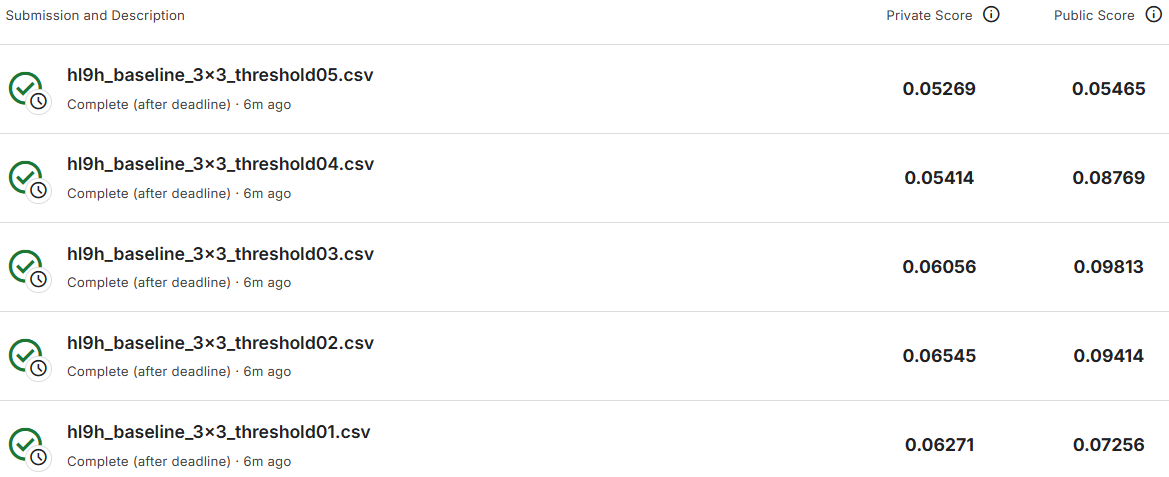
##### I can see that tiling at a 3x3 configuration significantly brought up the F1-scores (baseline with no-tiling were all below 0.01). At this configuration I got the best F1-scores using thresholds **between 0.2 and 0.3**, which means that lowering the threshold to 0.1 may lead to more false positive predictions.

In [14]:
# Keep scanning threshold from 0.6 to 0.7 

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.7, 0.6]
result_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t3, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result_df_list.append(result_df)

submit_df_thd07 = result_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd06 = result_df_list[1][["quadrat_id", "species_ids"]].copy()

submit_df_thd07['species_ids'] = submit_df_thd07['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd06['species_ids'] = submit_df_thd06['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd07.to_csv("hl9h_baseline_3x3_threshold07.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd06.to_csv("hl9h_baseline_3x3_threshold06.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Scanning thresholds ... 



Predicting: 100%|██████████| 2105/2105 [01:58<00:00, 17.82it/s]


In [15]:
# Proceed with the exploration of the Tiling Strategy

# Create inference data loader - "5 x 5" - for ResNet50

from loading import quadrat_loader

TILES_PER_SIDE = 5   # starting from 5x5 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader_t5 = quadrat_loader.main(     # t5: tiling of 5x5
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

# Check full inference data and data loader size 
len(inference_data), len(inference_loader_t5)   # 2105 minibatches - handle quadrats individually

Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---


(2105, 2105)

In [ ]:
DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
result5x5_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t5, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result5x5_df_list.append(result_df)


Using device: cpu
Scanning thresholds ... 



Predicting:   6%|▋         | 133/2105 [02:21<34:32,  1.05s/it]

In [ ]:
# Save dataframes for submission
submit_df_thd05 = result5x5_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd04 = result5x5_df_list[1][["quadrat_id", "species_ids"]].copy()
submit_df_thd03 = result5x5_df_list[2][["quadrat_id", "species_ids"]].copy()
submit_df_thd02 = result5x5_df_list[3][["quadrat_id", "species_ids"]].copy()
submit_df_thd01 = result5x5_df_list[4][["quadrat_id", "species_ids"]].copy()

submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(lambda x: [int(i) for i in x]) 
submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd05.to_csv("hl9h_baseline_5x5_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd04.to_csv("hl9h_baseline_5x5_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd03.to_csv("hl9h_baseline_5x5_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd02.to_csv("hl9h_baseline_5x5_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd01.to_csv("hl9h_baseline_5x5_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

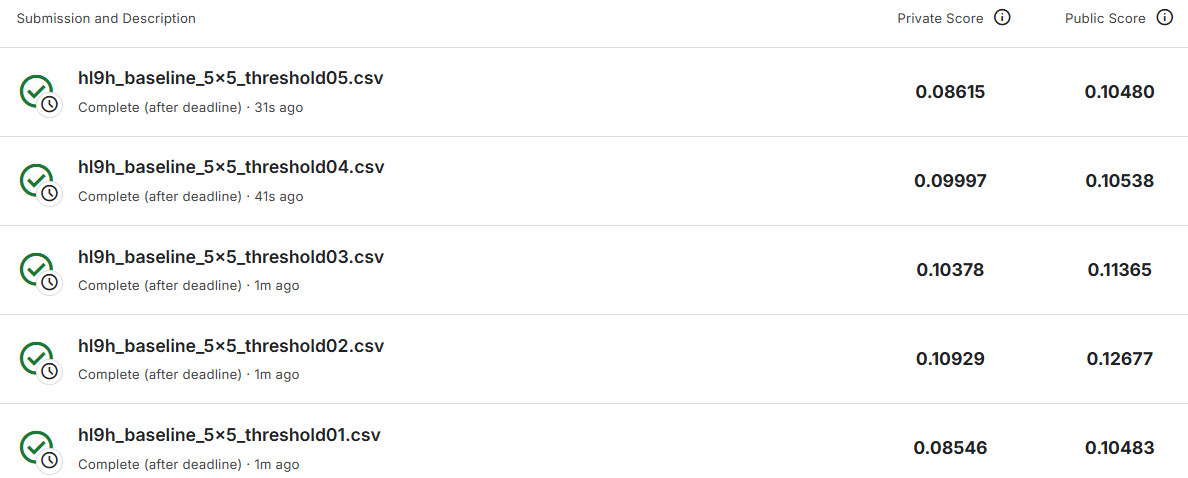
##### I can see that tiling with the 5x5 configuration brought up the F1-scores further compared to 3x3 tiling. At this configuration, the best F1-scores are still from the threshold **between 0.2 and 0.3**.

In [16]:
# Keep scanning threshold from 0.6 to 0.7 

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.7, 0.6]
result_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t5, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result_df_list.append(result_df)

submit_df_thd07 = result_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd06 = result_df_list[1][["quadrat_id", "species_ids"]].copy()

submit_df_thd07['species_ids'] = submit_df_thd07['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd06['species_ids'] = submit_df_thd06['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd07.to_csv("hl9h_baseline_5x5_threshold07.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd06.to_csv("hl9h_baseline_5x5_threshold06.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Scanning thresholds ... 



Predicting: 100%|██████████| 2105/2105 [02:26<00:00, 14.40it/s]


In [17]:
# Proceed with the exploration of the Tiling Strategy

# Create inference data loader - "7 x 7" - for ResNet50

from loading import quadrat_loader

TILES_PER_SIDE = 7   # starting from 7x7 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader_t7 = quadrat_loader.main(     # t7: tiling of 7x7
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
result7x7_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t7, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result7x7_df_list.append(result_df)

Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Using device: cuda
Scanning thresholds ... 



Predicting:   2%|▏         | 48/2105 [00:04<03:17, 10.40it/s]


KeyboardInterrupt: 

In [6]:
# Save dataframes for submission
submit_df_thd05 = result7x7_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd04 = result7x7_df_list[1][["quadrat_id", "species_ids"]].copy()
submit_df_thd03 = result7x7_df_list[2][["quadrat_id", "species_ids"]].copy()
submit_df_thd02 = result7x7_df_list[3][["quadrat_id", "species_ids"]].copy()
submit_df_thd01 = result7x7_df_list[4][["quadrat_id", "species_ids"]].copy()

submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(lambda x: [int(i) for i in x]) 
submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd05.to_csv("hl9h_baseline_7x7_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd04.to_csv("hl9h_baseline_7x7_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd03.to_csv("hl9h_baseline_7x7_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd02.to_csv("hl9h_baseline_7x7_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd01.to_csv("hl9h_baseline_7x7_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

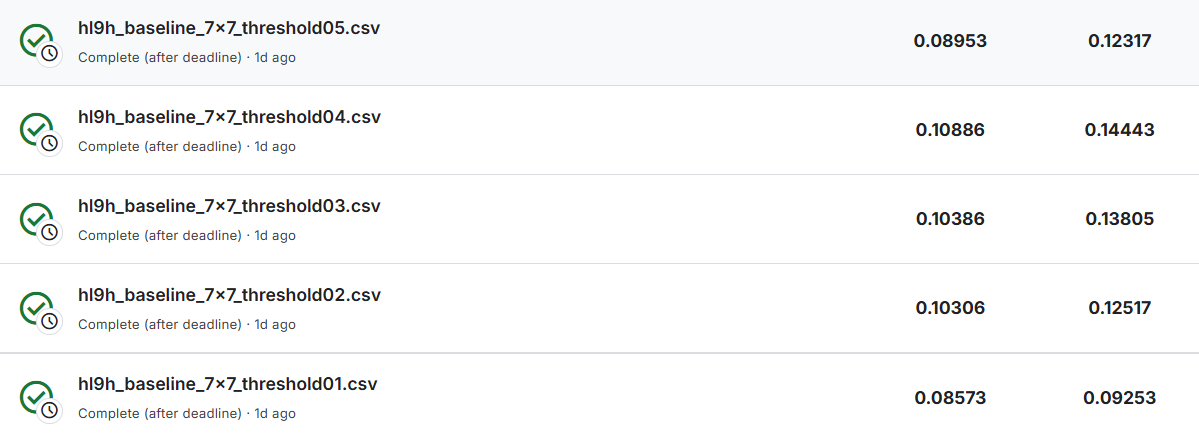
##### I can see that 7x7 configuration (at **threshold of 0.4**) achieved better F1-scores than 5x5, although overall they are still not promising.

In [ ]:
# Try new inference data loader (centercrop quadrats first) with "7 x 7" - for ResNet50

from loading import quadrat_loader

TILES_PER_SIDE = 7   # starting from 7x7 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader_t7 = quadrat_loader.main(     # t7: tiling of 7x7
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
result7x7_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t7, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result7x7_df_list.append(result_df)

# Save dataframes for submission
submit_df_thd05 = result7x7_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd04 = result7x7_df_list[1][["quadrat_id", "species_ids"]].copy()
submit_df_thd03 = result7x7_df_list[2][["quadrat_id", "species_ids"]].copy()
submit_df_thd02 = result7x7_df_list[3][["quadrat_id", "species_ids"]].copy()
submit_df_thd01 = result7x7_df_list[4][["quadrat_id", "species_ids"]].copy()

submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(lambda x: [int(i) for i in x]) 
submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd05.to_csv("hl9h_baseline_7x7new_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd04.to_csv("hl9h_baseline_7x7new_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd03.to_csv("hl9h_baseline_7x7new_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd02.to_csv("hl9h_baseline_7x7new_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd01.to_csv("hl9h_baseline_7x7new_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Using device: cpu
Scanning thresholds ... 



Predicting:  31%|███▏      | 663/2105 [14:25<33:35,  1.40s/it]

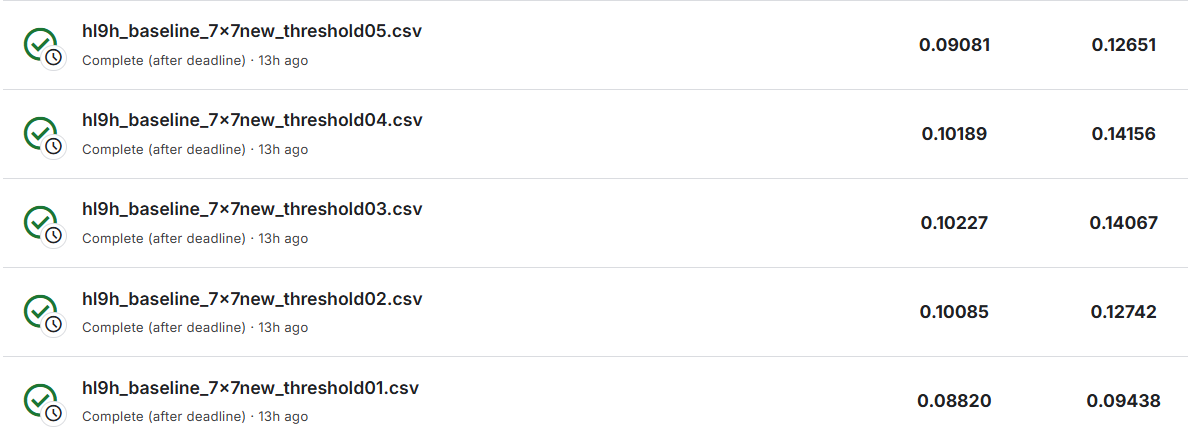
##### Interestingly, the new inference data loading strategy (centercrop quadrats first, potentially remove wooden frame or tape pixels and avoid tile streching) does worse than the origial one.


In [5]:
# New inference data loader (centercrop quadrats first) + Removing duplicates in class mapping
# with "7 x 7" - for ResNet50

from loading import quadrat_loader

TILES_PER_SIDE = 7   # starting from 7x7 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader_t7 = quadrat_loader.main(     # t7: tiling of 7x7
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
result7x7_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t7, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result7x7_df_list.append(result_df)

# Save dataframes for submission
submit_df_thd05 = result7x7_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd04 = result7x7_df_list[1][["quadrat_id", "species_ids"]].copy()
submit_df_thd03 = result7x7_df_list[2][["quadrat_id", "species_ids"]].copy()
submit_df_thd02 = result7x7_df_list[3][["quadrat_id", "species_ids"]].copy()
submit_df_thd01 = result7x7_df_list[4][["quadrat_id", "species_ids"]].copy()

submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(lambda x: [int(i) for i in x]) 
submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd05.to_csv("hl9h_baseline_7x7new2_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd04.to_csv("hl9h_baseline_7x7new2_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd03.to_csv("hl9h_baseline_7x7new2_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd02.to_csv("hl9h_baseline_7x7new2_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd01.to_csv("hl9h_baseline_7x7new2_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Using device: cuda
Scanning thresholds ... 



Predicting: 100%|██████████| 2105/2105 [02:43<00:00, 12.84it/s]


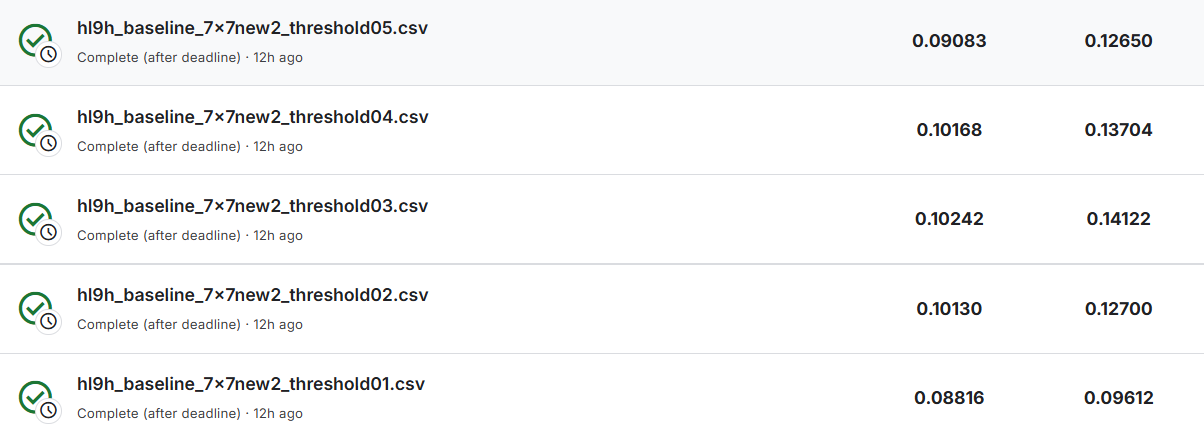
##### The result does not change much but removing duplicates in the class mapping step is definitely necessary. 

In [18]:
# Keep scanning threshold from 0.6 to 0.7 

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.7, 0.6]
result_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t7, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result_df_list.append(result_df)

submit_df_thd07 = result_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd06 = result_df_list[1][["quadrat_id", "species_ids"]].copy()

submit_df_thd07['species_ids'] = submit_df_thd07['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd06['species_ids'] = submit_df_thd06['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd07.to_csv("hl9h_baseline_7x7_threshold07.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd06.to_csv("hl9h_baseline_7x7_threshold06.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Scanning thresholds ... 



Predicting: 100%|██████████| 2105/2105 [02:52<00:00, 12.24it/s]


In [6]:
# Proceed with the exploration of the Tiling Strategy

# Back to original data loader + Removing duplicate in class mapping
# with "9 x 9" - for ResNet50

from loading import quadrat_loader

TILES_PER_SIDE = 9   # starting from 9x9 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader_t9 = quadrat_loader.main(     # t9: tiling of 9x9
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
result9x9_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t9, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result9x9_df_list.append(result_df)

# Save dataframes for submission
submit_df_thd05 = result9x9_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd04 = result9x9_df_list[1][["quadrat_id", "species_ids"]].copy()
submit_df_thd03 = result9x9_df_list[2][["quadrat_id", "species_ids"]].copy()
submit_df_thd02 = result9x9_df_list[3][["quadrat_id", "species_ids"]].copy()
submit_df_thd01 = result9x9_df_list[4][["quadrat_id", "species_ids"]].copy()

submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(lambda x: [int(i) for i in x]) 
submit_df_thd04['species_ids'] = submit_df_thd04['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd03['species_ids'] = submit_df_thd03['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd02['species_ids'] = submit_df_thd02['species_ids'].apply(lambda x: [int(i) for i in x])
submit_df_thd01['species_ids'] = submit_df_thd01['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd05.to_csv("hl9h_baseline_9x9_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd04.to_csv("hl9h_baseline_9x9_threshold04.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd03.to_csv("hl9h_baseline_9x9_threshold03.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd02.to_csv("hl9h_baseline_9x9_threshold02.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd01.to_csv("hl9h_baseline_9x9_threshold01.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Using device: cuda
Scanning thresholds ... 



Predicting: 100%|██████████| 2105/2105 [03:21<00:00, 10.45it/s]


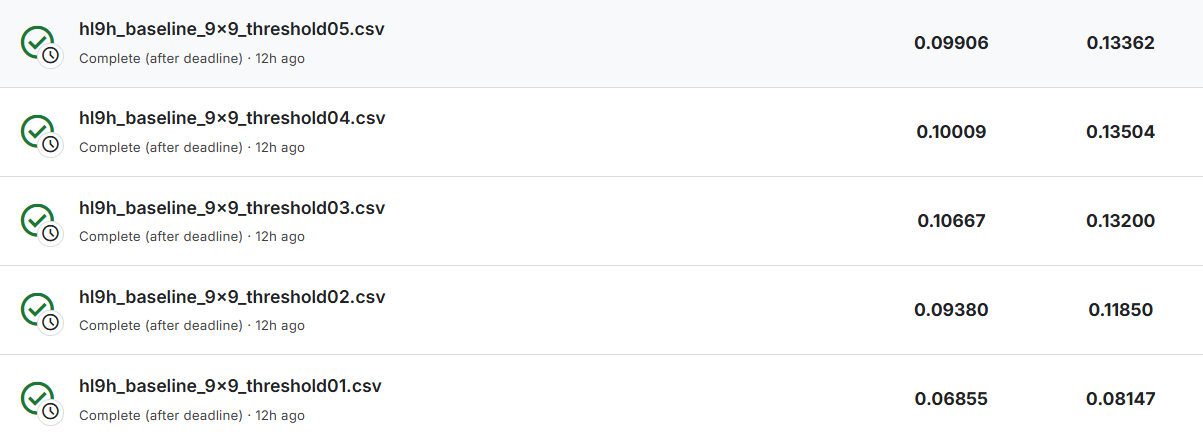
##### It appears that 9x9 tiling does not perform as well as 7x7 tiling.
##### The best of 7x7 tiling (threshold of 0.4): 0.109 and 0.144, while the best of 9x9 tiling (threshold of 0.3): 0.107 and 0.132.

In [19]:
# Keep scanning threshold from 0.6 to 0.7 

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 9   # starting from 9x9 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores

inference_data, inference_loader_t9 = quadrat_loader.main(     # t9: tiling of 9x9
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

thresholds = [0.7, 0.6]
result_df_list = []

print("Scanning thresholds ... \n")
for thd in thresholds:    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t9, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_to_df(idx_list, idx_to_cls_mapdict)
    result_df_list.append(result_df)

submit_df_thd07 = result_df_list[0][["quadrat_id", "species_ids"]].copy()
submit_df_thd06 = result_df_list[1][["quadrat_id", "species_ids"]].copy()

submit_df_thd07['species_ids'] = submit_df_thd07['species_ids'].apply(lambda x: [int(i) for i in x])   # convert each str to int
submit_df_thd06['species_ids'] = submit_df_thd06['species_ids'].apply(lambda x: [int(i) for i in x])

submit_df_thd07.to_csv("hl9h_baseline_9x9_threshold07.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
submit_df_thd06.to_csv("hl9h_baseline_9x9_threshold06.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds ... 



Predicting: 100%|██████████| 2105/2105 [03:34<00:00,  9.82it/s]


In [3]:
# Try pooling the results from different tiling inferences (at the best threshold respectively)
# 5x5 @ threshold 0.2
# 7x7 @ threshold 0.4 (also the overall best)
# 9x9 @ threshold 0.3

from ast import literal_eval

df_5x5 = pd.read_csv("resnet50_inference_results/hl9h_baseline_5x5_threshold02.csv")
df_7x7 = pd.read_csv("resnet50_inference_results/hl9h_baseline_7x7_threshold04.csv")
df_9x9 = pd.read_csv("resnet50_inference_results/hl9h_baseline_9x9_threshold03.csv")

df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""

merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)
merged_5_7_9


,quadrat_id,species_ids_5x5,species_ids_7x7,species_ids_9x9
0,2024-CEV3-20240602,"[1394636, 1392608, 1362443, 1396481, 1392598, ...","[1360187, 1360193, 1360208]","[1391989, 1356804, 1395045, 1392608]"
1,CBN-PdlC-A1-20130807,"[1396471, 1396471, 1394641, 1742052, 1391869, ...","[1396471, 1396471, 1396471, 1396471, 1743924]","[1489036, 1392662, 1396471, 1722444, 1392565, ..."
2,CBN-PdlC-A1-20130903,"[1392632, 1394540, 1397468, 1396857, 1396857, ...","[1392626, 1742052, 1392608, 1394336, 1396417, ...","[1392050, 1412857, 1743971, 1394641, 1742052, ..."
3,CBN-PdlC-A1-20140721,"[1390846, 1363741, 1393314, 1390793, 1355992, ...","[1395718, 1743924, 1396869]","[1394911, 1744235, 1363741, 1393771, 1355992, ..."
4,CBN-PdlC-A1-20140811,"[1393824, 1397528, 1393824, 1396733, 1412857, ...","[1412857, 1412857, 1392608, 1743913, 1392608]","[1412857, 1395974, 1390793, 1356359, 1392608]"
...,...,...,...,...
2100,RNNB-8-5-20240118,"[1655199, 1359344]",[1359344],"[1356598, 1359344, 1390532, 1397225]"
2101,RNNB-8-6-20240118,"[1363302, 1363434]","[1359344, 1359344, 1359344]","[1356598, 1357981, 1359344, 1392172]"
2102,RNNB-8-7-20240118,"[1359344, 1359344, 1359344, 1363477, 1359344, ...","[1359344, 1359804, 1359344, 1359344]","[1357848, 1359344, 1743408, 1359804, 1394838, ..."
2103,RNNB-8-8-20240118,"[1359344, 1359297, 1359344, 1359344, 1363892, ...","[1359344, 1357227, 1363892, 1359344, 1359344, ...","[1359344, 1357227, 1357236, 1393494, 1395973, ..."


In [4]:
merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                merged_5_7_9['species_ids_7x7'] + \
                                merged_5_7_9['species_ids_9x9']
merged_5_7_9

,quadrat_id,species_ids_5x5,species_ids_7x7,species_ids_9x9,species_ids
0,2024-CEV3-20240602,"[1394636, 1392608, 1362443, 1396481, 1392598, ...","[1360187, 1360193, 1360208]","[1391989, 1356804, 1395045, 1392608]","[1394636, 1392608, 1362443, 1396481, 1392598, ..."
1,CBN-PdlC-A1-20130807,"[1396471, 1396471, 1394641, 1742052, 1391869, ...","[1396471, 1396471, 1396471, 1396471, 1743924]","[1489036, 1392662, 1396471, 1722444, 1392565, ...","[1396471, 1396471, 1394641, 1742052, 1391869, ..."
2,CBN-PdlC-A1-20130903,"[1392632, 1394540, 1397468, 1396857, 1396857, ...","[1392626, 1742052, 1392608, 1394336, 1396417, ...","[1392050, 1412857, 1743971, 1394641, 1742052, ...","[1392632, 1394540, 1397468, 1396857, 1396857, ..."
3,CBN-PdlC-A1-20140721,"[1390846, 1363741, 1393314, 1390793, 1355992, ...","[1395718, 1743924, 1396869]","[1394911, 1744235, 1363741, 1393771, 1355992, ...","[1390846, 1363741, 1393314, 1390793, 1355992, ..."
4,CBN-PdlC-A1-20140811,"[1393824, 1397528, 1393824, 1396733, 1412857, ...","[1412857, 1412857, 1392608, 1743913, 1392608]","[1412857, 1395974, 1390793, 1356359, 1392608]","[1393824, 1397528, 1393824, 1396733, 1412857, ..."
...,...,...,...,...,...
2100,RNNB-8-5-20240118,"[1655199, 1359344]",[1359344],"[1356598, 1359344, 1390532, 1397225]","[1655199, 1359344, 1359344, 1356598, 1359344, ..."
2101,RNNB-8-6-20240118,"[1363302, 1363434]","[1359344, 1359344, 1359344]","[1356598, 1357981, 1359344, 1392172]","[1363302, 1363434, 1359344, 1359344, 1359344, ..."
2102,RNNB-8-7-20240118,"[1359344, 1359344, 1359344, 1363477, 1359344, ...","[1359344, 1359804, 1359344, 1359344]","[1357848, 1359344, 1743408, 1359804, 1394838, ...","[1359344, 1359344, 1359344, 1363477, 1359344, ..."
2103,RNNB-8-8-20240118,"[1359344, 1359297, 1359344, 1359344, 1363892, ...","[1359344, 1357227, 1363892, 1359344, 1359344, ...","[1359344, 1357227, 1357236, 1393494, 1395973, ...","[1359344, 1359297, 1359344, 1359344, 1363892, ..."


In [40]:
# Check for correct merge of the three columns
merged_5_7_9.iloc[0, 1], merged_5_7_9.iloc[0, 2], merged_5_7_9.iloc[0, 3], merged_5_7_9.iloc[0, 4]

([1394636, 1392608, 1362443, 1396481, 1392598, 1360187],
 [1360187, 1360193, 1360208],
 [1391989, 1356804, 1395045, 1392608],
 [1394636,
  1392608,
  1362443,
  1396481,
  1392598,
  1360187,
  1360187,
  1360193,
  1360208,
  1391989,
  1356804,
  1395045,
  1392608])

In [6]:
# Remove duplicates (this method does not preserve order)
merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))
merged_5_7_9.iloc[0, 4]

[1392608,
 1396481,
 1360193,
 1356804,
 1395045,
 1362443,
 1394636,
 1360208,
 1391989,
 1392598,
 1360187]

In [8]:
# Save the data frame
merged_5_7_9.to_csv("hl9h_baseline_pooling_579_bestthds.csv", sep=',', index=False)
merged_5_7_9[['quadrat_id', 'species_ids']].to_csv("submission_hl9h_baseline_pooling_579_bestthds.csv", 
                                                   sep=',', 
                                                   index=False, 
                                                   quoting=csv.QUOTE_ALL)

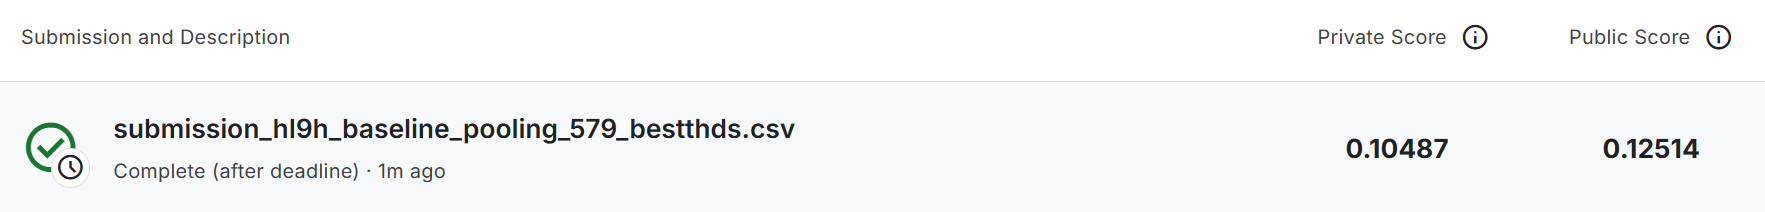


In [9]:
# Try pooling the results from different tiling inferences (with the same threshold)
# This gets the most confident predictions of each model
# 5x5 @ threshold 0.5
# 7x7 @ threshold 0.5
# 9x9 @ threshold 0.5

from ast import literal_eval

df_5x5 = pd.read_csv("resnet50_inference_results/hl9h_baseline_5x5_threshold05.csv")
df_7x7 = pd.read_csv("resnet50_inference_results/hl9h_baseline_7x7_threshold05.csv")
df_9x9 = pd.read_csv("resnet50_inference_results/hl9h_baseline_9x9_threshold05.csv")

df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""

merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                merged_5_7_9['species_ids_7x7'] + \
                                merged_5_7_9['species_ids_9x9']

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))

merged_5_7_9.to_csv("hl9h_baseline_pooling_579_threshold05.csv", sep=',', index=False)
merged_5_7_9[['quadrat_id', 'species_ids']].to_csv("submission_hl9h_baseline_pooling_579_threshold05.csv", 
                                                   sep=',', 
                                                   index=False, 
                                                   quoting=csv.QUOTE_ALL)

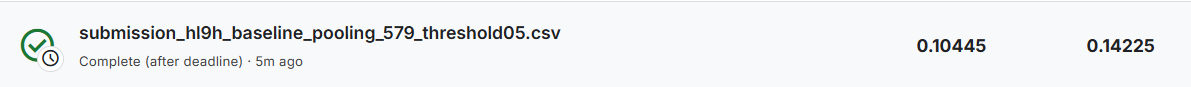


In [10]:
# Try pooling the results from different tiling inferences (with the same threshold)
# This gets the most confident predictions of each model
# 5x5 @ threshold 0.4
# 7x7 @ threshold 0.4 (also the overall best)
# 9x9 @ threshold 0.4

from ast import literal_eval

df_5x5 = pd.read_csv("resnet50_inference_results/hl9h_baseline_5x5_threshold04.csv")
df_7x7 = pd.read_csv("resnet50_inference_results/hl9h_baseline_7x7_threshold04.csv")
df_9x9 = pd.read_csv("resnet50_inference_results/hl9h_baseline_9x9_threshold04.csv")

df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""

merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                merged_5_7_9['species_ids_7x7'] + \
                                merged_5_7_9['species_ids_9x9']

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))

merged_5_7_9.to_csv("hl9h_baseline_pooling_579_threshold04.csv", sep=',', index=False)
merged_5_7_9[['quadrat_id', 'species_ids']].to_csv("submission_hl9h_baseline_pooling_579_threshold04.csv", 
                                                   sep=',', 
                                                   index=False, 
                                                   quoting=csv.QUOTE_ALL)

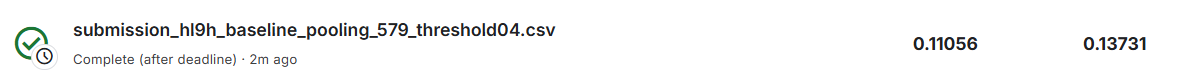


In [11]:
# Try pooling the results from different tiling inferences (with the same threshold)
# This gets the most confident predictions of each model
# 5x5 @ threshold 0.3
# 7x7 @ threshold 0.3
# 9x9 @ threshold 0.3

from ast import literal_eval

df_5x5 = pd.read_csv("resnet50_inference_results/hl9h_baseline_5x5_threshold03.csv")
df_7x7 = pd.read_csv("resnet50_inference_results/hl9h_baseline_7x7_threshold03.csv")
df_9x9 = pd.read_csv("resnet50_inference_results/hl9h_baseline_9x9_threshold03.csv")

df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""

merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                merged_5_7_9['species_ids_7x7'] + \
                                merged_5_7_9['species_ids_9x9']

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))

merged_5_7_9.to_csv("hl9h_baseline_pooling_579_threshold03.csv", sep=',', index=False)
merged_5_7_9[['quadrat_id', 'species_ids']].to_csv("submission_hl9h_baseline_pooling_579_threshold03.csv", 
                                                   sep=',', 
                                                   index=False, 
                                                   quoting=csv.QUOTE_ALL)

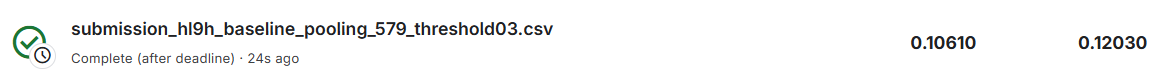

In [20]:
# Try pooling the results from different tiling inferences (with the same threshold)
# This gets the most confident predictions of each model
# 5x5 @ threshold 0.6
# 7x7 @ threshold 0.6
# 9x9 @ threshold 0.6

from ast import literal_eval

df_5x5 = pd.read_csv("hl9h_baseline_5x5_threshold06.csv")
df_7x7 = pd.read_csv("hl9h_baseline_7x7_threshold06.csv")
df_9x9 = pd.read_csv("hl9h_baseline_9x9_threshold06.csv")

df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""

merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                merged_5_7_9['species_ids_7x7'] + \
                                merged_5_7_9['species_ids_9x9']

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))

merged_5_7_9.to_csv("hl9h_baseline_pooling_579_threshold06.csv", sep=',', index=False)
merged_5_7_9[['quadrat_id', 'species_ids']].to_csv("submission_hl9h_baseline_pooling_579_threshold06.csv", 
                                                   sep=',', 
                                                   index=False, 
                                                   quoting=csv.QUOTE_ALL)

In [3]:
# Try pooling the results from different tiling inferences (with the same threshold)
# This gets the most confident predictions of each model
# 5x5 @ threshold 0.7
# 7x7 @ threshold 0.7
# 9x9 @ threshold 0.7

from ast import literal_eval

df_5x5 = pd.read_csv("hl9h_baseline_5x5_threshold07.csv")
df_7x7 = pd.read_csv("hl9h_baseline_7x7_threshold07.csv")
df_9x9 = pd.read_csv("hl9h_baseline_9x9_threshold07.csv")

df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""

merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                merged_5_7_9['species_ids_7x7'] + \
                                merged_5_7_9['species_ids_9x9']

merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))

merged_5_7_9.to_csv("hl9h_baseline_pooling_579_threshold07.csv", sep=',', index=False)
merged_5_7_9[['quadrat_id', 'species_ids']].to_csv("submission_hl9h_baseline_pooling_579_threshold07.csv", 
                                                   sep=',', 
                                                   index=False, 
                                                   quoting=csv.QUOTE_ALL)

In [ ]:
#======================================================
# ResNet50 Encoder: knn prediction with FAISS + Tiling
#======================================================
'''
Required a lot of memory, 128G only processed 16% of the training data.

'''

In [ ]:
from resnet50 import resnet50_encoder

idx_list = resnet50_encoder.knn_multi_label_prediction(
                            training_data_path, 
                            inference_data_path, 
                            tiles_per_side=3, 
                            k=5, 
                            threshold=0.25)

result_df = pred_idx_to_df(idx_list)
submit_df_thd01 = result9x9_df_list[4][["quadrat_id", "species_ids"]].copy()

submit_df_thd05['species_ids'] = submit_df_thd05['species_ids'].apply(lambda x: [int(i) for i in x]) 

submit_df_thd05.to_csv("hl9h_baseline_9x9_threshold05.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)


Using device: cuda
Found 1408033 total images belonging to 7806 classes.

--- Train Dataloader Pipeline Created ---
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Found 2105 total quadrat images.

--- Inference Dataloader Pipeline Created ---
Extracting training features...


Extracting features ...:   8%|▊         | 3501/44002 [20:47<3:55:11,  2.87it/s]

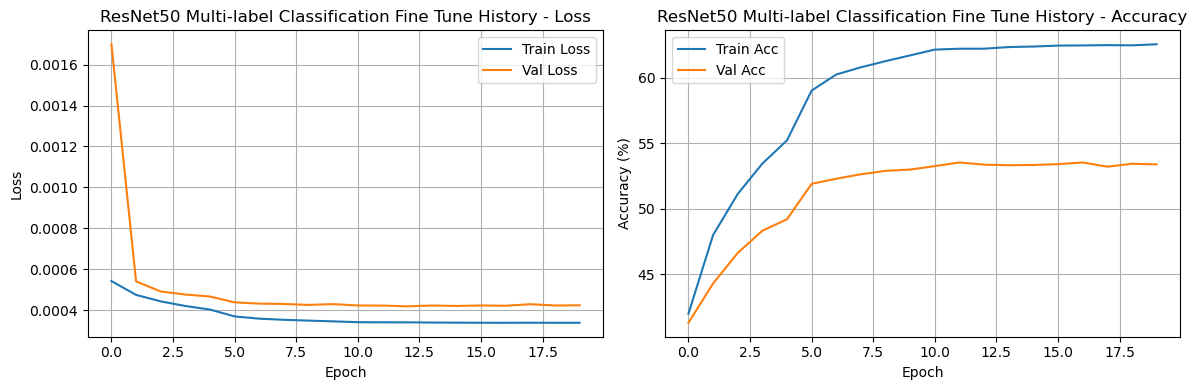

In [3]:
from resnet50 import resnet50_multilabel
finetune_history = pd.read_csv("resnet50/resnet50_multilabel_finetune_history.csv")
resnet50_multilabel.plot_training_history(finetune_history, "ResNet50 Multi-label Classification Fine Tune History")

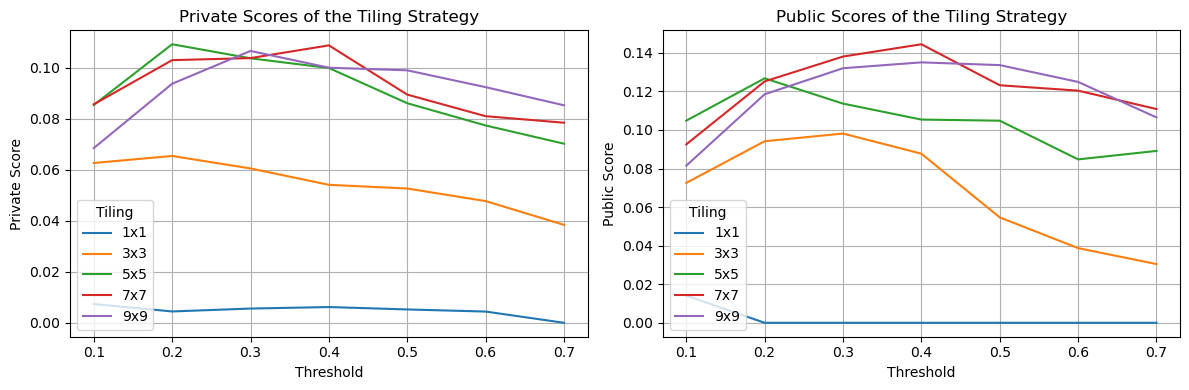

In [21]:
submission_history = pd.read_csv("resnet50_inference_results/resnet50_multilabel_submission_history.csv")
sub_his_nopool = submission_history[submission_history["tiling"] != "pooling"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for grouped_label, sub_df in sub_his_nopool.groupby("tiling"):    
    ax1.plot(sub_df['threshold'], sub_df['private_score'], label=grouped_label)
    ax2.plot(sub_df['threshold'], sub_df['public_score'], label=grouped_label)
    
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Private Score')
ax1.set_title(f'Private Scores of the Tiling Strategy')
ax1.legend(title='Tiling', loc='lower left')
ax1.grid(True)
ax2.set_xlabel('Threshold')

ax2.set_ylabel('Public Score')
ax2.set_title(f'Public Scores of the Tiling Strategy')
ax2.legend(title='Tiling', loc='lower left')
ax2.grid(True)

plt.tight_layout()   
plt.show()


In [ ]:
#=========================================================================
# Baseline 3: ResNet50 multi-label classifier + Tiling + Frequency voting
#=========================================================================
'''
Based on baseline 2 results, will only explore tiling 5x5, 7x7, 9x9 at threshold from 0.1 to 0.7.

'''

In [4]:
# Get the trained ResNet50 multi-label classifier and initialize configuration
from loading import quadrat_loader
from resnet50 import resnet50_multilabel   # get pretrained ResNet50 and helper functions

NUM_CLASS = 7806

resnet50_multilabel_model = resnet50_multilabel.get_resnet50_pretrained(num_classes=NUM_CLASS, fine_tune=False)
state_dict = torch.load('resnet50_multilabel_finetune_plantCLEF.pth', map_location=torch.device('cpu'), weights_only=True)  # weights_only=True is recommended for security
resnet50_multilabel_model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
# Load the saved (idx-cls, cls-idx) mapping dictionaries back:
with open('resnet50/cls_to_idx_mapdict.json', 'r') as f:
    cls_to_idx_mapdict = json.load(f)

with open('resnet50/idx_to_cls_mapdict.json', 'r') as g:
    idx_to_cls_mapdict = json.load(g)
    
print(f"Mapping dictionaries loaded!\n")

Mapping dictionaries loaded!



In [5]:
# 5x5 tiling + voting with default cutoff=0.25

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 5   # starting from 5x5 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t5 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t5, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.25)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_voting_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
    

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 5x5 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [02:26<00:00, 14.40it/s]


In [5]:
# 7x7 tiling + voting with default cutoff=0.25

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 7   # starting from 7x7 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t7 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t7, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.25)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_voting_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 7x7 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [02:56<00:00, 11.91it/s]


In [6]:
# 9x9 tiling + voting with default cutoff=0.25

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 9   # starting from 9x9 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t9 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t9, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.25)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_voting_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 9x9 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [03:35<00:00,  9.75it/s]


In [3]:
# Pooling the results from different Tiling + Frequency voting with default cutoff for each threshold
# 5x5 @ threshold 0.1 to 0.7
# 7x7 @ threshold 0.1 to 0.7
# 9x9 @ threshold 0.1 to 0.7

from ast import literal_eval
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i, thd in enumerate(THRESHOLDS):
    df_5x5 = pd.read_csv(f"hl9h_baseline_5x5_voting_thd0{i+1}.csv")
    df_7x7 = pd.read_csv(f"hl9h_baseline_7x7_voting_thd0{i+1}.csv")
    df_9x9 = pd.read_csv(f"hl9h_baseline_9x9_voting_thd0{i+1}.csv")
    
    df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
    df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
    df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""
    
    merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
    merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
    merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)
    
    merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                    merged_5_7_9['species_ids_7x7'] + \
                                    merged_5_7_9['species_ids_9x9']
    
    merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))
    
    merged_5_7_9.to_csv(f"hl9h_baseline_voting_pooling_579_thd0{i+1}.csv", sep=',', index=False)
    merged_5_7_9[['quadrat_id', 'species_ids']].to_csv(f"submission_hl9h_baseline_voting_pooling_579_thd0{i+1}.csv", 
                                                       sep=',', 
                                                       index=False, 
                                                       quoting=csv.QUOTE_ALL)

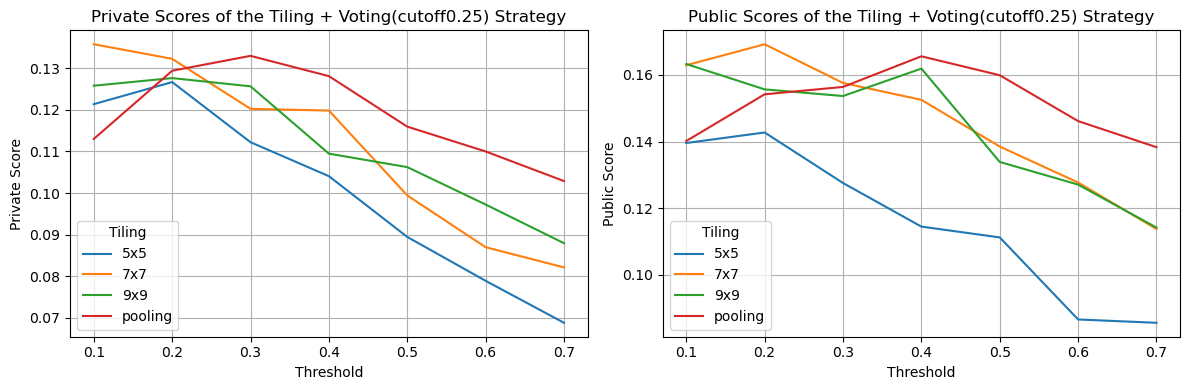

In [15]:
tiling_voting025_submission_history = pd.read_csv("resnet50_inference_results/resnet50_multilabel_votingcutoff025_submission_history.csv")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for grouped_label, sub_df in tiling_voting_submission_history.groupby("tiling"):    
    ax1.plot(sub_df['threshold'], sub_df['private_score'], label=grouped_label)
    ax2.plot(sub_df['threshold'], sub_df['public_score'], label=grouped_label)
    
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Private Score')
ax1.set_title(f'Private Scores of the Tiling + Voting(cutoff0.25) Strategy')
ax1.legend(title='Tiling', loc='lower left')
ax1.grid(True)
ax2.set_xlabel('Threshold')

ax2.set_ylabel('Public Score')
ax2.set_title(f'Public Scores of the Tiling + Voting(cutoff0.25) Strategy')
ax2.legend(title='Tiling', loc='lower left')
ax2.grid(True)

plt.tight_layout()   
plt.show()

In [5]:
# 5x5 tiling + voting with cutoff=0.5

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 5   # starting from 5x5 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t5 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t5, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.5)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_votingcf05_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)
    

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 5x5 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [02:14<00:00, 15.66it/s]


In [6]:
# 7x7 tiling + voting with cutoff=0.5

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 7   # starting from 7x7 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t7 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t7, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.5)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_votingcf05_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 7x7 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [02:43<00:00, 12.86it/s]


In [7]:
# 9x9 tiling + voting with cutoff=0.5

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 9   # starting from 9x9 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t9 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t9, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.5)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_votingcf05_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 9x9 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [03:25<00:00, 10.24it/s]


In [8]:
# Pooling the results from different Tiling + Frequency voting at cutoff=0.5 for each threshold
# 5x5 @ threshold 0.1 to 0.7
# 7x7 @ threshold 0.1 to 0.7
# 9x9 @ threshold 0.1 to 0.7

from ast import literal_eval
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i, thd in enumerate(THRESHOLDS):
    df_5x5 = pd.read_csv(f"hl9h_baseline_5x5_votingcf05_thd0{i+1}.csv")
    df_7x7 = pd.read_csv(f"hl9h_baseline_7x7_votingcf05_thd0{i+1}.csv")
    df_9x9 = pd.read_csv(f"hl9h_baseline_9x9_votingcf05_thd0{i+1}.csv")
    
    df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
    df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
    df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""
    
    merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
    merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
    merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)
    
    merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                    merged_5_7_9['species_ids_7x7'] + \
                                    merged_5_7_9['species_ids_9x9']
    
    merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))
    
    merged_5_7_9.to_csv(f"hl9h_baseline_votingcf05_pooling_579_thd0{i+1}.csv", sep=',', index=False)
    merged_5_7_9[['quadrat_id', 'species_ids']].to_csv(f"submission_hl9h_baseline_votingcf05_pooling_579_thd0{i+1}.csv", 
                                                       sep=',', 
                                                       index=False, 
                                                       quoting=csv.QUOTE_ALL)

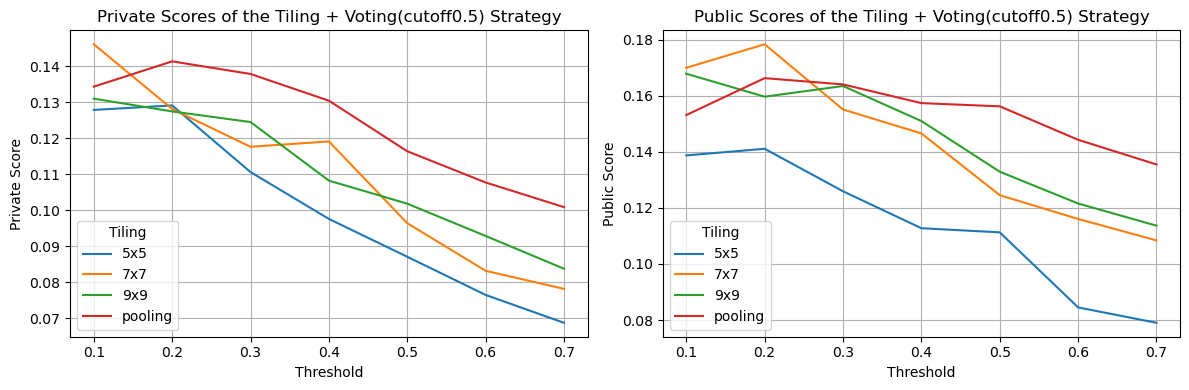

In [14]:
tiling_voting05_submission_history = pd.read_csv("resnet50_inference_results/resnet50_multilabel_votingcutoff05_submission_history.csv")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for grouped_label, sub_df in tiling_voting05_submission_history.groupby("tiling"):    
    ax1.plot(sub_df['threshold'], sub_df['private_score'], label=grouped_label)
    ax2.plot(sub_df['threshold'], sub_df['public_score'], label=grouped_label)
    
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Private Score')
ax1.set_title(f'Private Scores of the Tiling + Voting(cutoff0.5) Strategy')
ax1.legend(title='Tiling', loc='lower left')
ax1.grid(True)
ax2.set_xlabel('Threshold')

ax2.set_ylabel('Public Score')
ax2.set_title(f'Public Scores of the Tiling + Voting(cutoff0.5) Strategy')
ax2.legend(title='Tiling', loc='lower left')
ax2.grid(True)

plt.tight_layout()   
plt.show()

In [6]:
# 5x5 tiling + voting with cutoff=0.75

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 5   # starting from 5x5 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t5 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t5, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.75)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_votingcf075_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 5x5 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [02:17<00:00, 15.35it/s]


In [7]:
# 7x7 tiling + voting with cutoff=0.75

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 7   # starting from 7x7 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t7 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t7, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.75)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_votingcf075_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 7x7 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [02:44<00:00, 12.76it/s]


In [8]:
# 9x9 tiling + voting with cutoff=0.75

DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')

TILES_PER_SIDE = 9   # starting from 9x9 tiling
IMG_SIZE = 224 
BATCH_SIZE = 1   # since we are processing multiple tiles per sample/quadrat image, we consider 1 image = 1 batch
NUM_WORKERS = 4   # number of CPU cores
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

inference_data, inference_loader_t9 = quadrat_loader.main(
                                       inference_data_path, 
                                       tiles_per_side=TILES_PER_SIDE,
                                       target_size=IMG_SIZE, 
                                       batch_size=BATCH_SIZE, 
                                       num_workers=NUM_WORKERS)

print(f"Scanning thresholds for {TILES_PER_SIDE}x{TILES_PER_SIDE} tiling with voting strategy ... \n")
for i, thd in enumerate(THRESHOLDS):    
    idx_list = resnet50_multilabel.multi_label_prediction(resnet50_multilabel_model, inference_loader_t9, DEVICE, threshold=thd)    
    result_df = resnet50_multilabel.pred_idx_vote_aggr_to_df(idx_list, idx_to_cls_mapdict, cutoff=0.75)
    
    submit_df = result_df[["quadrat_id", "species_ids"]].copy()
    submit_df['species_ids'] = submit_df['species_ids'].apply(lambda x: [int(j) for j in x])   # convert each str to int
    submit_df.to_csv(f"hl9h_baseline_{TILES_PER_SIDE}x{TILES_PER_SIDE}_votingcf075_thd0{i+1}.csv", sep=',', index=False, quoting=csv.QUOTE_ALL)

Using device: cuda
Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/test_images/images

--- Dataloader Pipelines Created ---
Scanning thresholds for 9x9 tiling with voting strategy ... 



Predicting: 100%|██████████| 2105/2105 [03:21<00:00, 10.43it/s]


In [9]:
# Pooling the results from different Tiling + Frequency voting at cutoff=0.75 for each threshold
# 5x5 @ threshold 0.1 to 0.7
# 7x7 @ threshold 0.1 to 0.7
# 9x9 @ threshold 0.1 to 0.7

from ast import literal_eval
THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i, thd in enumerate(THRESHOLDS):
    df_5x5 = pd.read_csv(f"hl9h_baseline_5x5_votingcf075_thd0{i+1}.csv")
    df_7x7 = pd.read_csv(f"hl9h_baseline_7x7_votingcf075_thd0{i+1}.csv")
    df_9x9 = pd.read_csv(f"hl9h_baseline_9x9_votingcf075_thd0{i+1}.csv")
    
    df_5x5['species_ids'] = df_5x5['species_ids'].apply(literal_eval)   # remove quotes ""
    df_7x7['species_ids'] = df_7x7['species_ids'].apply(literal_eval)   # remove quotes ""
    df_9x9['species_ids'] = df_9x9['species_ids'].apply(literal_eval)   # remove quotes ""
    
    merged_5_7 = pd.merge(df_5x5, df_7x7, on='quadrat_id', suffixes=('_5x5','_7x7'))
    merged_5_7_9 = pd.merge(merged_5_7, df_9x9, on='quadrat_id')
    merged_5_7_9.rename(columns={'species_ids': 'species_ids_9x9'}, inplace=True)
    
    merged_5_7_9['species_ids'] = merged_5_7_9['species_ids_5x5'] + \
                                    merged_5_7_9['species_ids_7x7'] + \
                                    merged_5_7_9['species_ids_9x9']
    
    merged_5_7_9['species_ids'] = merged_5_7_9['species_ids'].apply(lambda x: list(set(x)))
    
    merged_5_7_9.to_csv(f"hl9h_baseline_votingcf075_pooling_579_thd0{i+1}.csv", sep=',', index=False)
    merged_5_7_9[['quadrat_id', 'species_ids']].to_csv(f"submission_hl9h_baseline_votingcf075_pooling_579_thd0{i+1}.csv", 
                                                       sep=',', 
                                                       index=False, 
                                                       quoting=csv.QUOTE_ALL)

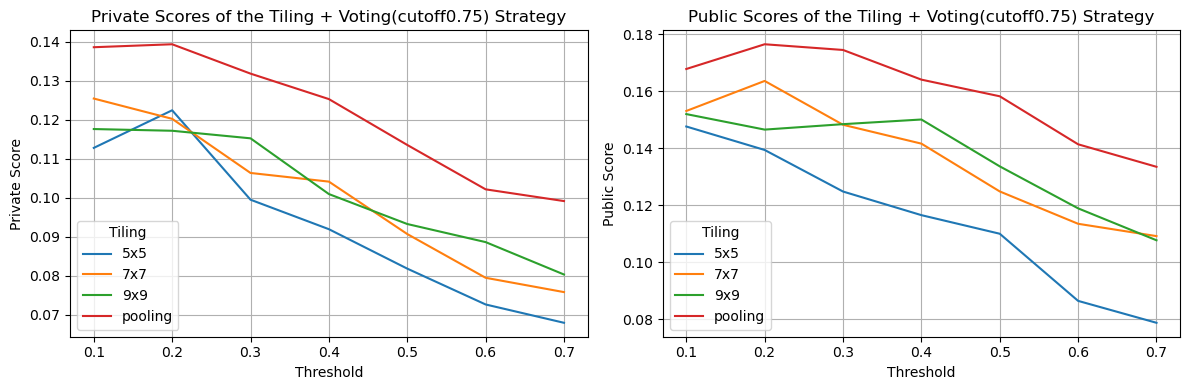

In [12]:
tiling_voting075_submission_history = pd.read_csv("resnet50_inference_results/resnet50_multilabel_votingcutoff075_submission_history.csv")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for grouped_label, sub_df in tiling_voting075_submission_history.groupby("tiling"):    
    ax1.plot(sub_df['threshold'], sub_df['private_score'], label=grouped_label)
    ax2.plot(sub_df['threshold'], sub_df['public_score'], label=grouped_label)
    
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Private Score')
ax1.set_title(f'Private Scores of the Tiling + Voting(cutoff0.75) Strategy')
ax1.legend(title='Tiling', loc='lower left')
ax1.grid(True)

ax2.set_xlabel('Threshold')
ax2.set_ylabel('Public Score')
ax2.set_title(f'Public Scores of the Tiling + Voting(cutoff0.75) Strategy')
ax2.legend(title='Tiling', loc='lower left')
ax2.grid(True)

plt.tight_layout()   
plt.show()

In [17]:
pooling025 = tiling_voting025_submission_history[tiling_voting025_submission_history['tiling'] == 'pooling']
pooling025

,tiling,threshold,private_score,public_score
21,pooling,0.1,0.11302,0.14019
22,pooling,0.2,0.12943,0.15420
23,pooling,0.3,0.13301,0.15641
24,pooling,0.4,0.12813,0.16560
25,pooling,0.5,0.11598,0.15992
26,pooling,0.6,0.11001,0.14616
27,pooling,0.7,0.10288,0.13834


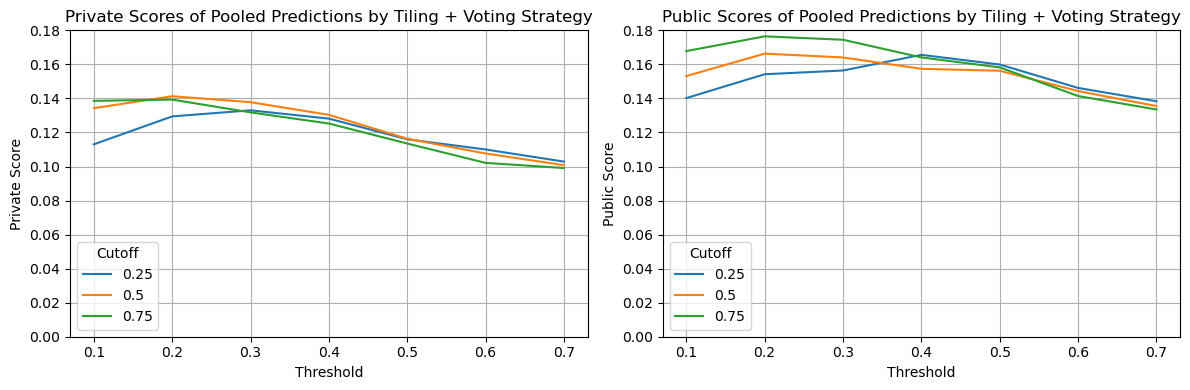

In [20]:
pooling025 = tiling_voting025_submission_history[tiling_voting025_submission_history['tiling'] == 'pooling']
pooling05 = tiling_voting05_submission_history[tiling_voting05_submission_history['tiling'] == 'pooling']
pooling075 = tiling_voting075_submission_history[tiling_voting075_submission_history['tiling'] == 'pooling']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
   
ax1.plot(pooling025['threshold'], pooling025['private_score'], label=0.25)
ax1.plot(pooling05['threshold'], pooling05['private_score'], label=0.50)
ax1.plot(pooling075['threshold'], pooling075['private_score'], label=0.75)
ax1.set_ylim([0.00, 0.18])

ax2.plot(pooling025['threshold'], pooling025['public_score'], label=0.25)
ax2.plot(pooling05['threshold'], pooling05['public_score'], label=0.50)
ax2.plot(pooling075['threshold'], pooling075['public_score'], label=0.75)
ax2.set_ylim([0.00, 0.18])

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Private Score')
ax1.set_title(f'Private Scores of Pooled Predictions by Tiling + Voting Strategy')
ax1.legend(title='Cutoff', loc='lower left')
ax1.grid(True)

ax2.set_xlabel('Threshold')
ax2.set_ylabel('Public Score')
ax2.set_title(f'Public Scores of Pooled Predictions by Tiling + Voting Strategy')
ax2.legend(title='Cutoff', loc='lower left')
ax2.grid(True)

plt.tight_layout()   
plt.show()